<a href="https://colab.research.google.com/github/mitsu666/Lecture2021/blob/main/Lecture07_LogisticReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実習ロジステイック回帰

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
os.chdir('/content/drive/My Drive/003_Project/data')

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 6.8MB/s 


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.metrics import mean_squared_error
import category_encoders as ce
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

sns.set(style='darkgrid')

In [ ]:
df = pd.read_csv('adult.data',header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus",
    "Occupation", "Relationship", "Race", "Gender", "CapitalGain",
    "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

In [ ]:
#describe
df.describe(include='all')

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


## 1. 変数変換

### 1.1 ダミー変数化

In [ ]:
#変数チェック
df.dtypes

Age               int64
WorkClass        object
fnlwgt            int64
Education        object
EducationNum      int64
MaritalStatus    object
Occupation       object
Relationship     object
Race             object
Gender           object
CapitalGain       int64
CapitalLoss       int64
HoursPerWeek      int64
NativeCountry    object
Income           object
dtype: object

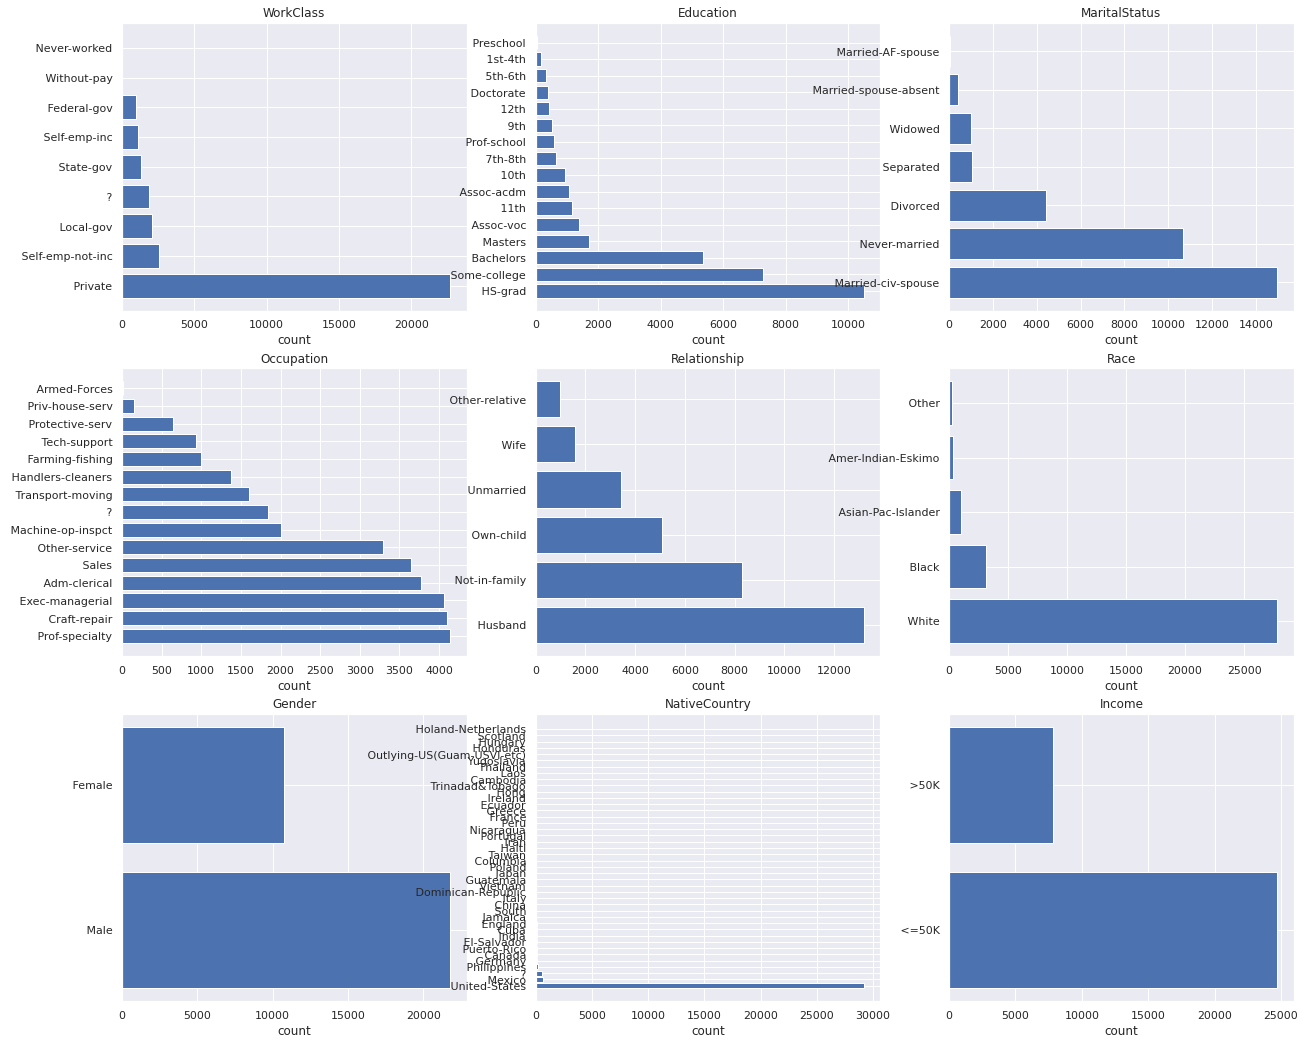

In [ ]:
plt.figure(figsize=(21,18))
for i,col in enumerate(df.select_dtypes(include='O').columns):
  plt.subplot(3,3,i+1)
  temp = df[col].value_counts(dropna=False)
  plt.barh(temp.index,temp)
  plt.xlabel('count')
  plt.title(col)

In [ ]:
#カテゴリ変数の空白削除
for i,col in enumerate(df.select_dtypes(include='O').columns):
  df[col] = df[col].str.strip()

In [ ]:
#目的変数を変換
df['Income'] = (df['Income']=='>50K').astype('int8') #'>50K then True が返ってくる、このTrueをint型になおすと1になる

([<matplotlib.axis.YTick at 0x7f50f677ef10>,
 <a list of 2 Text major ticklabel objects>)

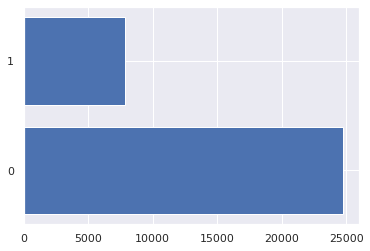

In [ ]:
plt.barh(df['Income'].value_counts(dropna=False).index,df['Income'].value_counts(dropna=False))
plt.yticks([0,1])

In [ ]:
#Educationを順序へ変換する
df['Education'].value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: Education, dtype: int64

In [ ]:
order = ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th','HS-grad','Prof-school','Assoc-acdm','Assoc-voc','Some-college','Bachelors','Masters','Doctorate']
order1 = [str(i).zfill(2)+':'+col for i,col in enumerate(order)]
#参考 https://sites.google.com/site/complexdataminingproject/

Text(0, 0.5, 'Proportion of 50k>')

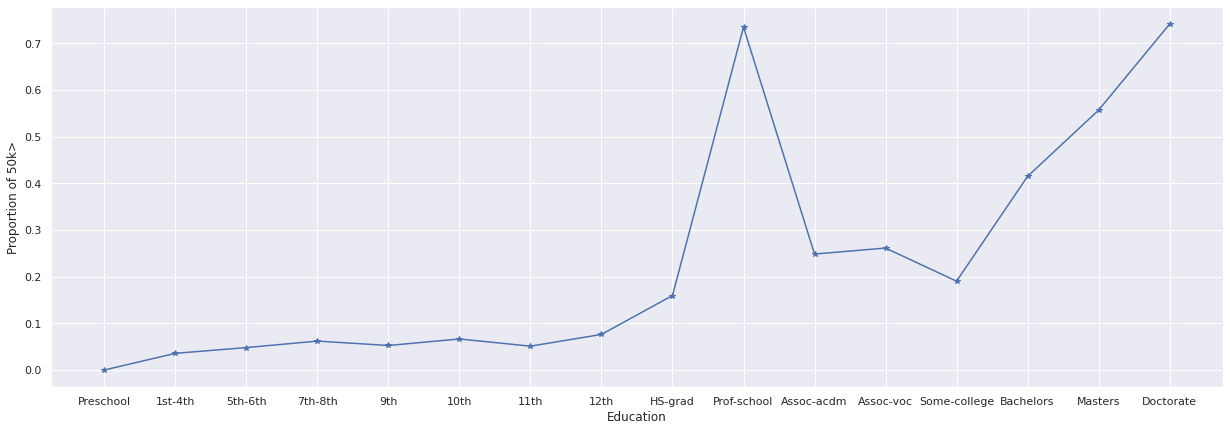

In [ ]:
plt.figure(figsize=(21,7))
temp = pd.concat([
           df.groupby('Education')['Income'].agg(['count','mean']),pd.DataFrame(order1,index=order)],
          axis=1
).sort_values(by=[0])

plt.plot(temp['mean'],marker='*')
plt.xlabel('Education')
plt.ylabel('Proportion of 50k>')
#plt.tciks(np.arange(len(order)))

In [ ]:
#(1) 順序変換準'備
map = [{'col':'Education',
       'mapping':{col:i for i,col in enumerate(order)}
}]

(map)

[{'col': 'Education',
  'mapping': {'10th': 5,
   '11th': 6,
   '12th': 7,
   '1st-4th': 1,
   '5th-6th': 2,
   '7th-8th': 3,
   '9th': 4,
   'Assoc-acdm': 10,
   'Assoc-voc': 11,
   'Bachelors': 13,
   'Doctorate': 15,
   'HS-grad': 8,
   'Masters': 14,
   'Preschool': 0,
   'Prof-school': 9,
   'Some-college': 12}}]

In [ ]:
encoder = ce.OrdinalEncoder(cols=['Education'],mapping=map)
encoder.fit(df)
df['Education'] = encoder.transform(df)['Education']

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Text(0, 0.5, 'Proportion of 50k>')

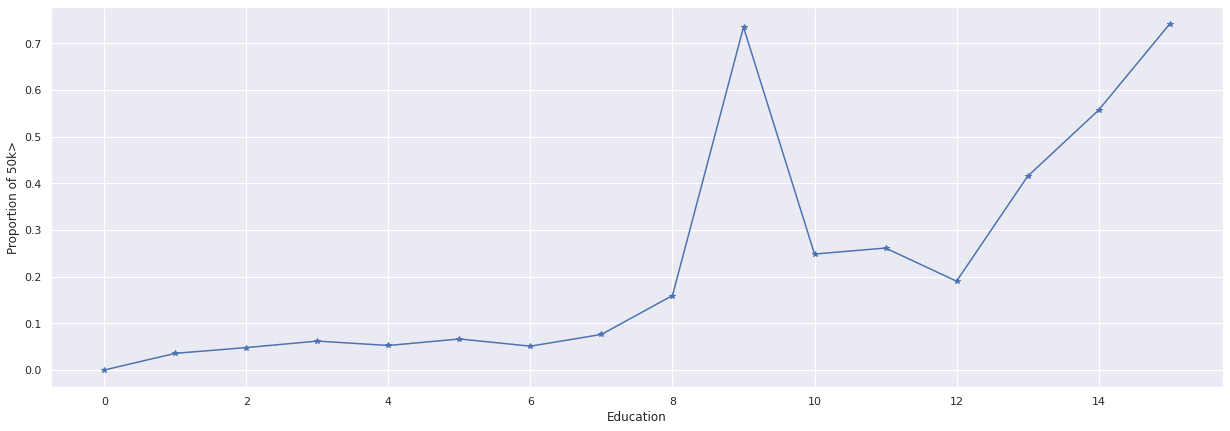

In [ ]:
plt.figure(figsize=(21,7))
temp = df.groupby('Education')['Income'].agg(['count','mean'])
plt.plot(temp['mean'],marker='*')
plt.xlabel('Education')
plt.ylabel('Proportion of 50k>')
#plt.tciks(np.arange(len(order)))

In [ ]:
df['Education']

0        13
1        13
2         8
3         6
4        13
         ..
32556    10
32557     8
32558     8
32559     8
32560     8
Name: Education, Length: 32561, dtype: int64

In [ ]:
#(2) native country 変換
df['NativeCountry'] = (df['NativeCountry']=='United-States').astype(int)

([<matplotlib.axis.YTick at 0x7f50f97a9d90>,
 [Text(0, 0, '0:Others'), Text(0, 0, '1:US')])

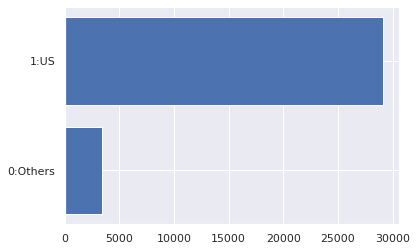

In [ ]:
plt.barh(df['NativeCountry'].value_counts(dropna=False).index,df['NativeCountry'].value_counts(dropna=False))
plt.yticks([0,1],['0:Others','1:US'])

In [ ]:
#(3) Occupation 変換
df.groupby(['Occupation'])['Income'].agg(['count','mean'])

,count,mean
Occupation,,
?,1843,0.103635
Adm-clerical,3770,0.134483
Armed-Forces,9,0.111111
Craft-repair,4099,0.226641
Exec-managerial,4066,0.484014
Farming-fishing,994,0.115694
Handlers-cleaners,1370,0.062774
Machine-op-inspct,2002,0.124875
Other-service,3295,0.041578


In [ ]:
#グループ化辞書
gdic = {}
gdic['G1'] = ['?','Armed-Forces']
gdic['G2'] = ['Handlers-cleaners','Other-service','Priv-house-serv']
gdic['G3'] = ['Adm-clerical','Machine-op-inspct']
gdic['G4'] = ['Craft-repair','Transport-moving']
gdic['G5'] = ['Exec-managerial','Prof-specialty']
gdic['G6'] = ['Protective-serv','Sales','Tech-support']
gdic['G7'] = ['Farming-fishing']

In [ ]:
#グループ分け
for k,v in gdic.items():
  df[k] = (df['Occupation'].isin(v)).astype('int8') 

In [ ]:
df.drop(columns='Occupation',axis=1,inplace=True)

In [ ]:
#残りのカテゴリ変数をワン・ホット・エンコーディングする
rest_cols = df.select_dtypes(include=('O')).columns

In [ ]:
encoder = ce.OneHotEncoder(cols=rest_cols,use_cat_names=True)
encoder.fit(df)
df = encoder.transform(df)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
rcols = [col for col in df.columns for rcol in rest_cols if col.find(rcol)>-1]
print (df[rcols].head().T)

                                     0  1  2  3  4
WorkClass_State-gov                  1  0  0  0  0
WorkClass_Self-emp-not-inc           0  1  0  0  0
WorkClass_Private                    0  0  1  1  1
WorkClass_Federal-gov                0  0  0  0  0
WorkClass_Local-gov                  0  0  0  0  0
WorkClass_?                          0  0  0  0  0
WorkClass_Self-emp-inc               0  0  0  0  0
WorkClass_Without-pay                0  0  0  0  0
WorkClass_Never-worked               0  0  0  0  0
MaritalStatus_Never-married          1  0  0  0  0
MaritalStatus_Married-civ-spouse     0  1  0  1  1
MaritalStatus_Divorced               0  0  1  0  0
MaritalStatus_Married-spouse-absent  0  0  0  0  0
MaritalStatus_Separated              0  0  0  0  0
MaritalStatus_Married-AF-spouse      0  0  0  0  0
MaritalStatus_Widowed                0  0  0  0  0
Relationship_Not-in-family           1  0  1  0  0
Relationship_Husband                 0  1  0  1  0
Relationship_Wife              

In [ ]:
#冗長であるためダミー変数1次元削減する
for k,v in {rcol:[col for col in df.columns if col.find(rcol)>-1] for rcol in rest_cols }.items():
  print (k,v[-1])
  df.drop(columns=v[-1],inplace=True)

WorkClass WorkClass_Never-worked
MaritalStatus MaritalStatus_Widowed
Relationship Relationship_Other-relative
Race Race_Other
Gender Gender_Female


In [ ]:
df.drop(columns='G7',inplace=True)

### 今回はこの時点で train test分けておく。

一番初めに分けるのが妥当である。しかし変数ダミー化などをする場合train/testでそれぞれ同じ処理を行うため、2度手間にならないように分ける前に行った。

以降の節からはtrainで学習した結果をtestに適用するためにこの時点でtrain/testに分ける。

In [ ]:
#件数がそれなりにあるため 5:5に分割
df_train, df_test = train_test_split(df,test_size=0.5)

print (df.shape)
print (df_train.shape)
print (df_test.shape)

(32561, 39)
(16280, 39)
(16281, 39)


### 1.2 線形性チェック

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:348: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:348: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:348: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/loca

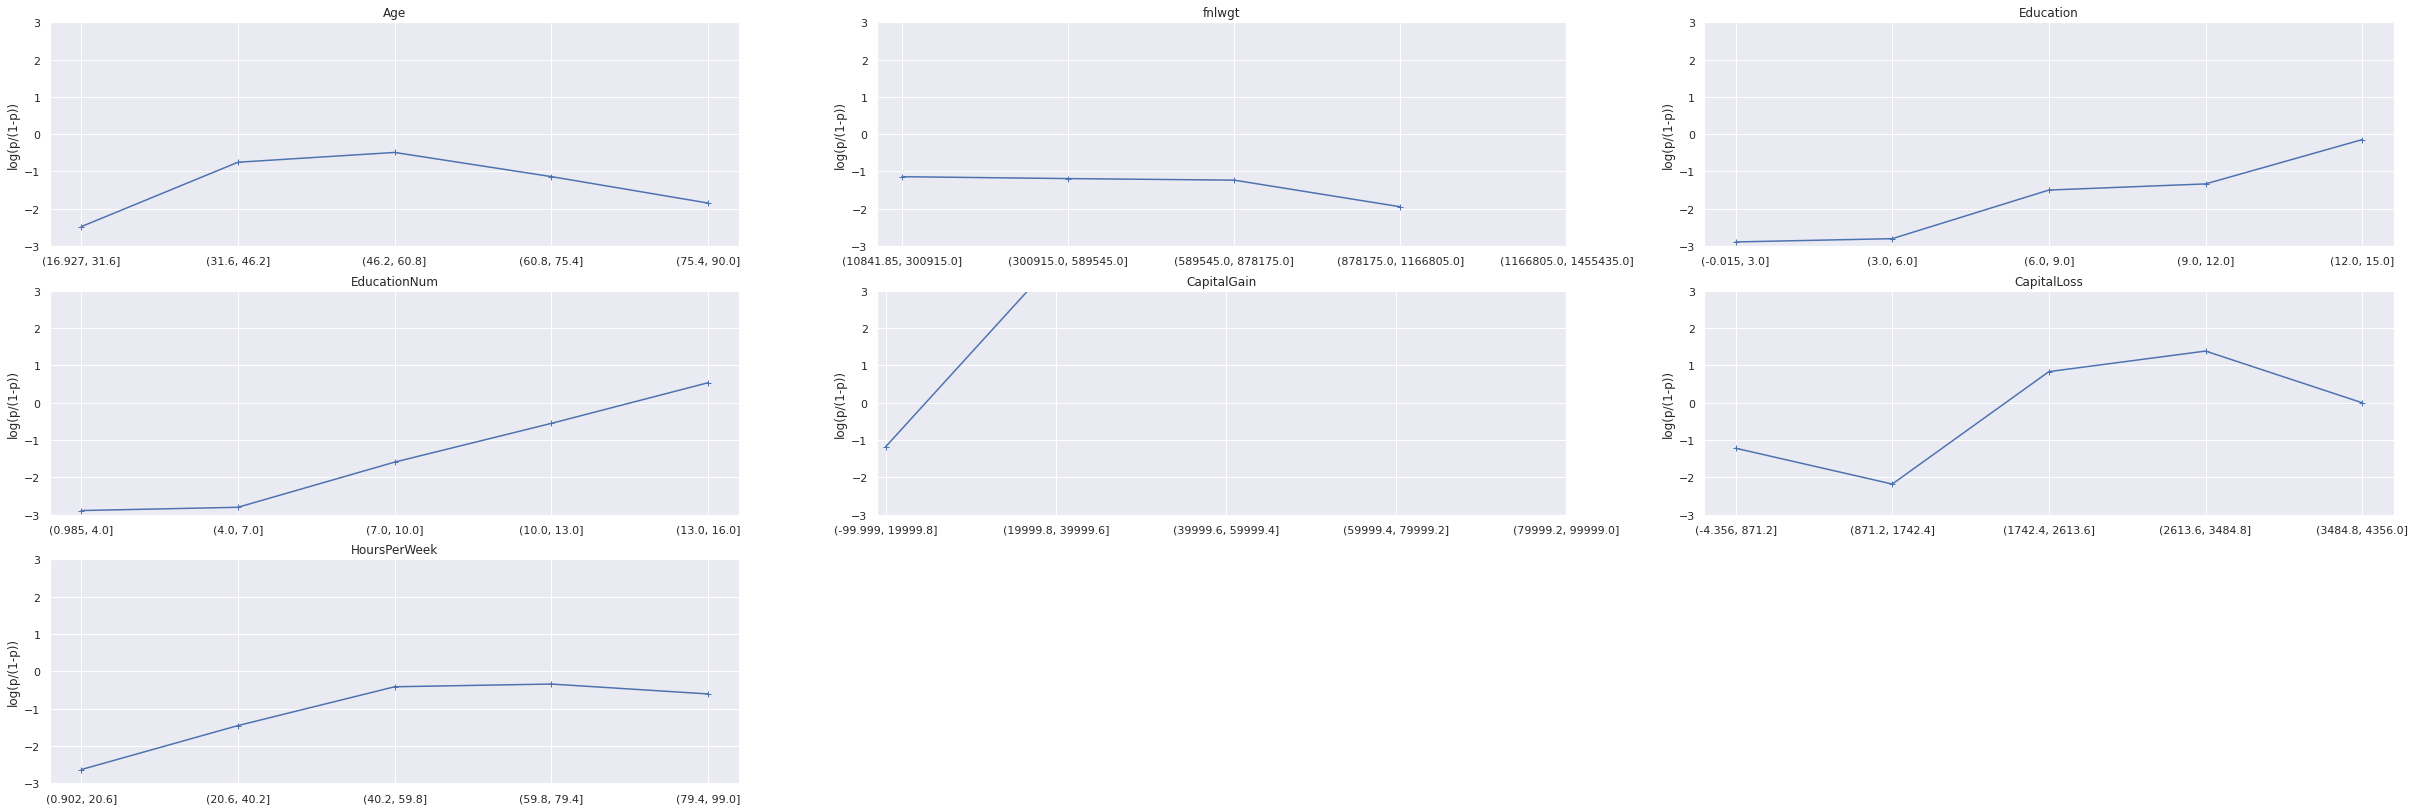

In [ ]:
#10以上のユニーク値がある数値変数の線形性チェック
l = []
plt.figure(figsize=(42,14))
for i,col in enumerate([col for col in df_train.columns if len(df_train[col].unique()) > 10]):
  temp = df_train.groupby(pd.cut(df_train[col],bins=5))['Income'].agg(['mean','count'])
  l.append(temp)
  plt.subplot(3,3,i+1)
  plt.plot(np.log(temp['mean'] / (1-temp['mean'])),marker='+')
  plt.title(col)
  plt.ylim(-3,3)
  plt.ylabel('log(p/(1-p))')
  plt.xticks(np.arange(5),temp.index)
  

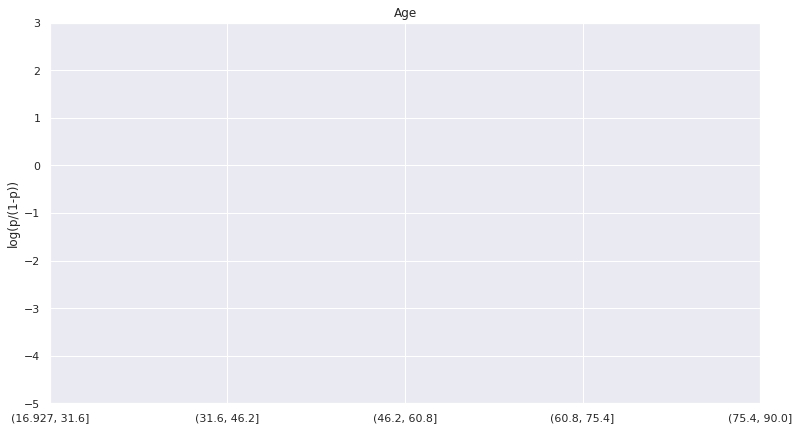

In [ ]:
l = []
plt.figure(figsize=(28,7))
for i,col in enumerate([col for col in df_train.columns if col.find('Age')>-1]):
  temp = df_train.groupby(pd.cut(df_train[col],bins=5))['Income'].agg(['mean','count'])
  l.append(temp)
  plt.subplot(1,2,i+1)
  #plt.plot(np.log(temp['mean'] / (1-temp['mean'])),marker='+')
  #ax2 = plt.twinx()
  #ax2.bar(np.arange(5),temp['count'])
  plt.title(col)
  plt.ylim(-5,3)
  plt.ylabel('log(p/(1-p))')
  plt.xticks(np.arange(5),temp.index)

In [ ]:
#testも同様に
df_test['Age_norm'] = -1*(df_test['Age']-50)**2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 2. 変数加工

### 2.1 欠損確認

In [ ]:
df_train.isnull().sum()

Age                                    0
WorkClass_State-gov                    0
WorkClass_Self-emp-not-inc             0
WorkClass_Private                      0
WorkClass_Federal-gov                  0
WorkClass_Local-gov                    0
WorkClass_?                            0
WorkClass_Self-emp-inc                 0
WorkClass_Without-pay                  0
fnlwgt                                 0
Education                              0
EducationNum                           0
MaritalStatus_Never-married            0
MaritalStatus_Married-civ-spouse       0
MaritalStatus_Divorced                 0
MaritalStatus_Married-spouse-absent    0
MaritalStatus_Separated                0
MaritalStatus_Married-AF-spouse        0
Relationship_Not-in-family             0
Relationship_Husband                   0
Relationship_Wife                      0
Relationship_Own-child                 0
Relationship_Unmarried                 0
Race_White                             0
Race_Black      

### 2.2 外れ値処理

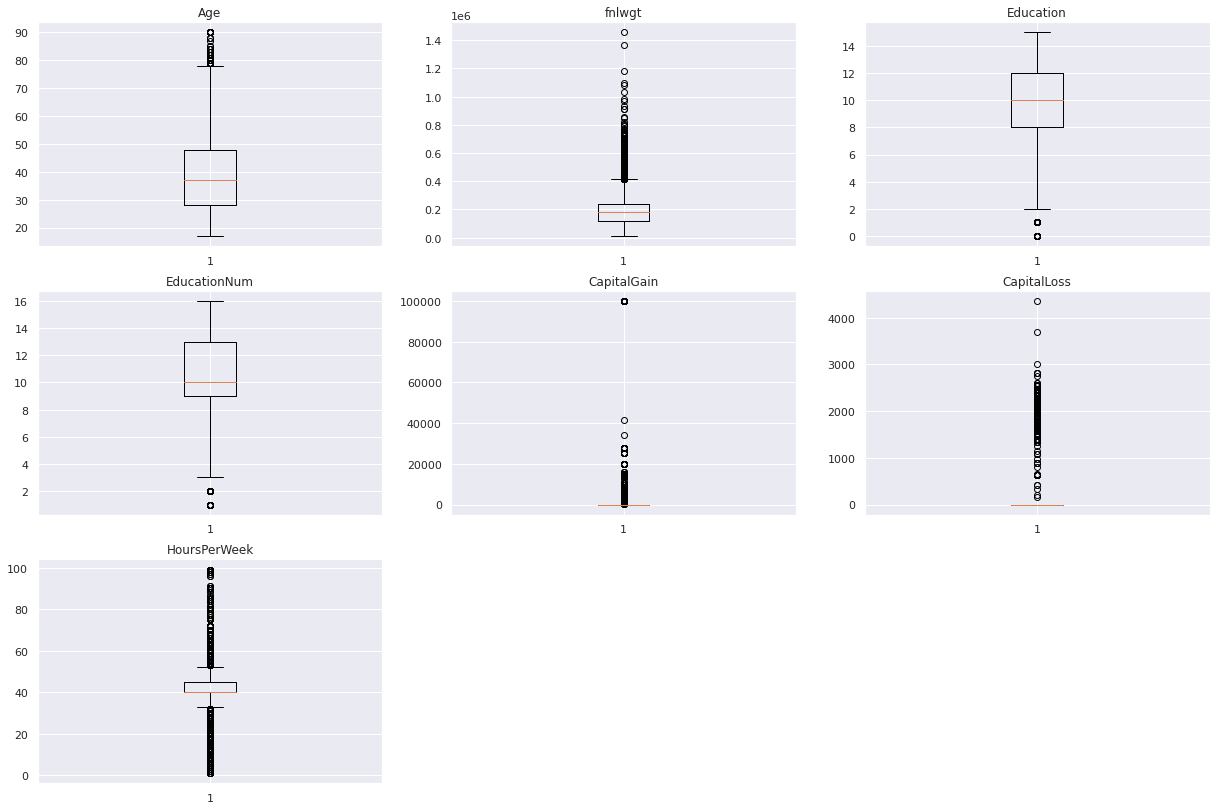

In [ ]:
l = []
plt.figure(figsize=(21,14))
for i,col in enumerate([col for col in df_train.columns if len(df_train[col].unique()) > 10]):
  plt.subplot(3,3,i+1)
  plt.boxplot(df_train[col])
  plt.title(col)

In [ ]:
#外れ値処理関数
def roundout(col,pct,train_col):
  pct_low = np.percentile(train_col,pct)
  pct_high = np.percentile(train_col,100-pct)
  col[col<pct_low] = pct_low
  col[col>pct_high] = pct_high
  return (col)

df_train.describe()

,Age,WorkClass_State-gov,WorkClass_Self-emp-not-inc,WorkClass_Private,WorkClass_Federal-gov,WorkClass_Local-gov,WorkClass_?,WorkClass_Self-emp-inc,WorkClass_Without-pay,fnlwgt,Education,EducationNum,MaritalStatus_Never-married,MaritalStatus_Married-civ-spouse,MaritalStatus_Divorced,MaritalStatus_Married-spouse-absent,MaritalStatus_Separated,MaritalStatus_Married-AF-spouse,Relationship_Not-in-family,Relationship_Husband,Relationship_Wife,Relationship_Own-child,Relationship_Unmarried,Race_White,Race_Black,Race_Asian-Pac-Islander,Race_Amer-Indian-Eskimo,Gender_Male,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income,G1,G2,G3,G4,G5,G6
count,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,1.628000e+04,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000
mean,38.683231,0.040356,0.079054,0.699201,0.029914,0.064005,0.053133,0.033722,0.000430,1.896378e+05,9.888329,10.077764,0.325369,0.463145,0.136916,0.013329,0.031327,0.000491,0.256941,0.408231,0.048034,0.151966,0.105344,0.852887,0.094963,0.032924,0.010258,0.672666,1093.484828,86.615049,40.444287,0.893243,0.241032,0.053501,0.147236,0.177826,0.178256,0.253071,0.160565
std,13.662765,0.196799,0.269831,0.458619,0.170355,0.244769,0.224305,0.180519,0.020732,1.055481e+05,3.022704,2.583807,0.468527,0.498655,0.343770,0.114684,0.174205,0.022163,0.436960,0.491521,0.213846,0.358999,0.307006,0.354229,0.293173,0.178443,0.100764,0.469255,7451.630975,399.655215,12.268024,0.308813,0.427723,0.225038,0.354352,0.382378,0.382739,0.434785,0.367141
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.228500e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.176830e+05,8.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.787800e+05,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,40.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.367310e+05,12.000000,13.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,45.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.455435e+06,15.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#99%タイルで丸める
for col in [col for col in df_train.columns if len(df_train[col].unique()) > 10]:
  roundout(df_train[col],100-99,df_train[col])
  roundout(df_test[col],100-99,df_train[col])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1

In [ ]:
df_train.describe()

,Age,WorkClass_State-gov,WorkClass_Self-emp-not-inc,WorkClass_Private,WorkClass_Federal-gov,WorkClass_Local-gov,WorkClass_?,WorkClass_Self-emp-inc,WorkClass_Without-pay,fnlwgt,Education,EducationNum,MaritalStatus_Never-married,MaritalStatus_Married-civ-spouse,MaritalStatus_Divorced,MaritalStatus_Married-spouse-absent,MaritalStatus_Separated,MaritalStatus_Married-AF-spouse,Relationship_Not-in-family,Relationship_Husband,Relationship_Wife,Relationship_Own-child,Relationship_Unmarried,Race_White,Race_Black,Race_Asian-Pac-Islander,Race_Amer-Indian-Eskimo,Gender_Male,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income,G1,G2,G3,G4,G5,G6
count,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000
mean,38.625246,0.040356,0.079054,0.699201,0.029914,0.064005,0.053133,0.033722,0.000430,188433.064520,9.896990,10.086425,0.325369,0.463145,0.136916,0.013329,0.031327,0.000491,0.256941,0.408231,0.048034,0.151966,0.105344,0.852887,0.094963,0.032924,0.010258,0.672666,642.585258,83.558170,40.408538,0.893243,0.241032,0.053501,0.147236,0.177826,0.178256,0.253071,0.160565
std,13.490689,0.196799,0.269831,0.458619,0.170355,0.244769,0.224305,0.180519,0.020732,99765.116228,2.998046,2.557664,0.468527,0.498655,0.343770,0.114684,0.174205,0.022163,0.436960,0.491521,0.213846,0.358999,0.307006,0.354229,0.293173,0.178443,0.100764,0.469255,2550.902718,382.644785,11.894472,0.308813,0.427723,0.225038,0.354352,0.382378,0.382739,0.434785,0.367141
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27064.060000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,117683.000000,8.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,178780.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,40.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,236731.000000,12.000000,13.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,45.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,74.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,506351.470000,15.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15024.000000,1980.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.3 標準化

In [ ]:
#目的変数と説明変数を分離
X_cols = df_train.columns.to_list()
X_cols.remove('Income')
X_train = df_train[X_cols]
X_test = df_test[X_cols]
y_train = df_train['Income']
y_test = df_test['Income']

In [ ]:
#標準化
scaler = StandardScaler() #標準化オブジェクト作成  
scaler.fit(X_train) #訓練データで平均と標準偏差を計算する
X_train = pd.DataFrame(scaler.transform(X_train),index=X_train.index,columns=X_train.columns) #訓練データの標準化
X_test = pd.DataFrame(scaler.transform(X_test),index=X_test.index,columns=X_test.columns) #検証データの標準化

## 3. 変数選択・モデリング

### 3.1 手動選択

In [ ]:
#fnlwgt	
dropl = ['fnlwgt','Age']
X_train.drop(columns=dropl,axis=1,inplace=True)
X_test.drop(columns=dropl,axis=1,inplace=True)

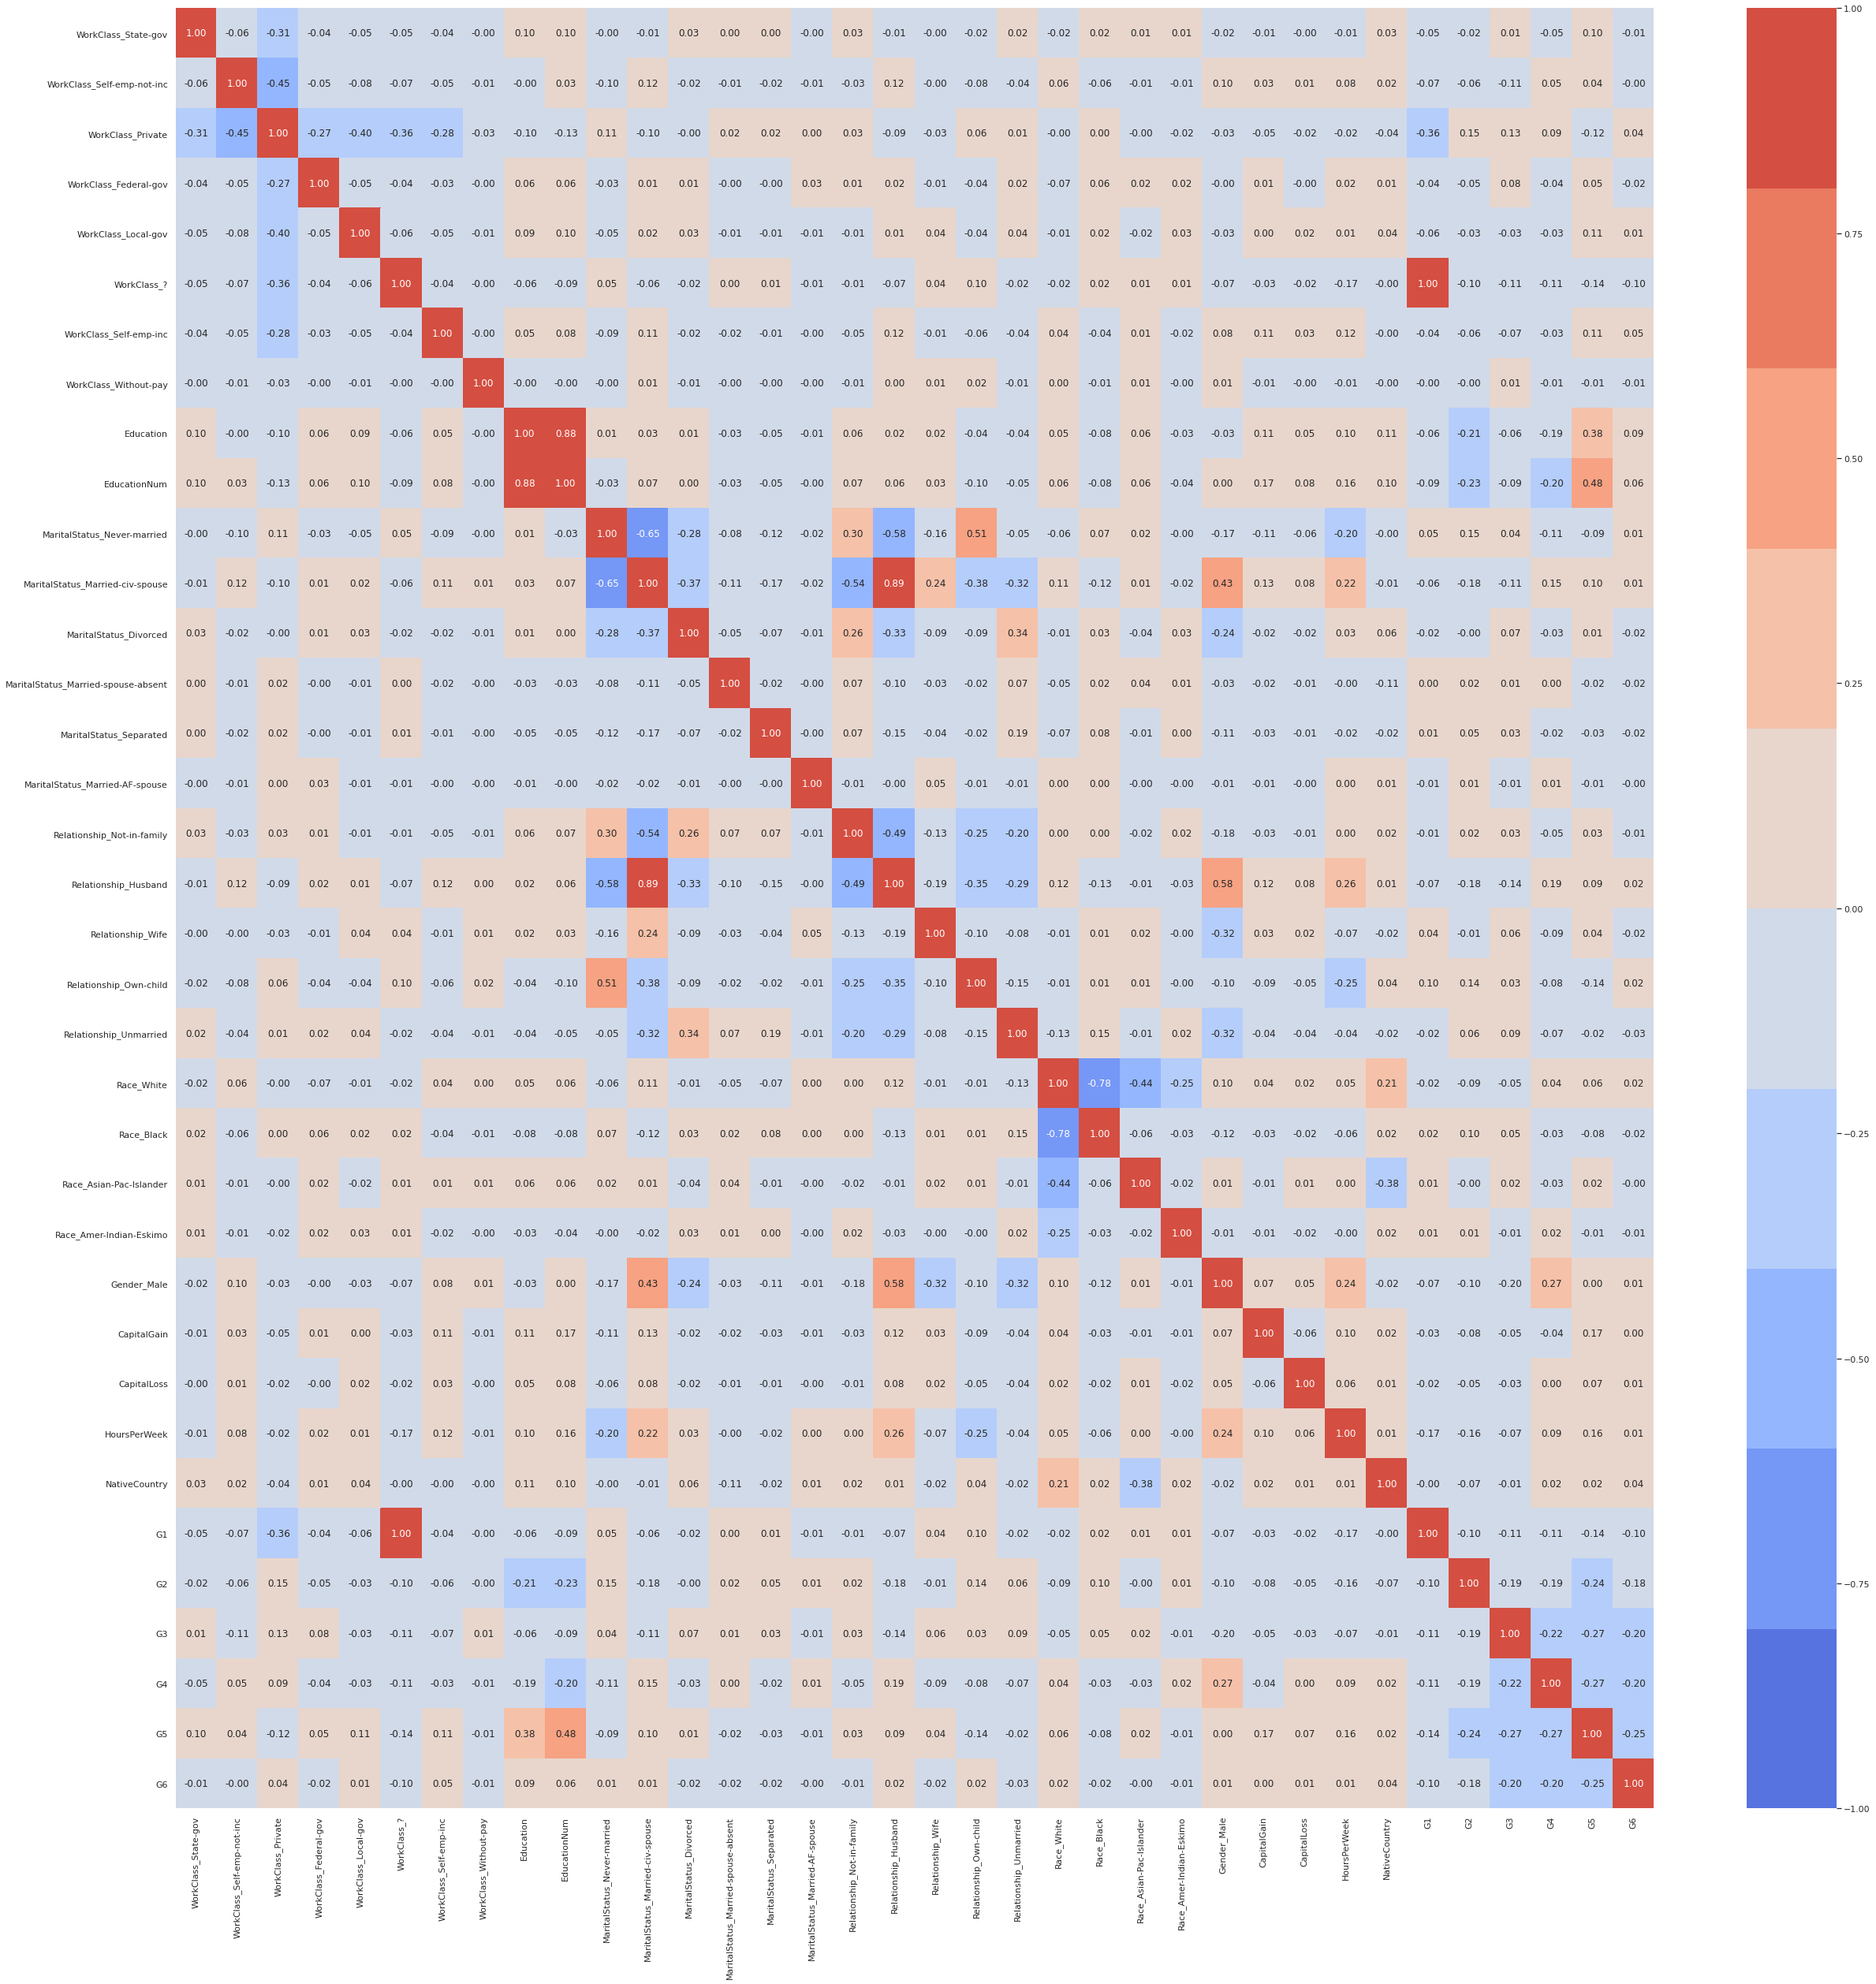

In [ ]:
corr = X_train.corr()
plt.figure(figsize=(42,42))
sns.heatmap(corr, cmap= sns.color_palette('coolwarm', 10), annot=True,fmt='.2f', vmin = -1, vmax = 1)

In [ ]:
#0.6より大きいもの抽出
dict1 = {}
for num in np.arange(corr.shape[0]):
  temp = corr.iloc[num,:][np.abs(corr.iloc[num,:])>0.6].index.to_list()
  temp.remove(corr.index[num])
  if len(temp)>0:
    dict1[corr.index[num]] = temp

In [ ]:
#削除変数リスト作成
l = []
for k,v in dict1.items():
  if k in l:
    print (k,"dont append")
  else:
    l += v

EducationNum dont append
MaritalStatus_Married-civ-spouse dont append
Race_Black dont append
G1 dont append


In [ ]:
X_train = X_train.drop(columns=set(l),axis=1)
X_test = X_test.drop(columns=set(l),axis=1)

### 4.2 モデリング・変数自動選択

In [ ]:
def forward_select(data,target):
  variate=set(data.columns)    # Convert field names to dictionary types
  #variate.remove(target)    # Remove the field name of the dependent variable
  selected=[]
  current_score,best_new_score=float('inf'),float('inf')    #The current score and the best score initial value are infinite (becauseAICThe smaller the better) 
        # Filter variable
  #data = sm.add_constant(data, prepend=False)

  while variate:
    aic_with_variate=[]
    for candidate in variate:    ## traverse the arguments one by one
      #formula="{}~{}".format(target,"+".join(selected+[candidate]))    #Connect the argument names
      aic=sm.Logit(target,sm.add_constant(data[selected+[candidate]],prepend=False)).fit().aic #Using the ols training model to get the aic value
      aic_with_variate.append((aic,candidate))    # put the first aic value into the empty list
    aic_with_variate.sort(reverse=True)    #Descending order aic value
    best_new_score,best_candidate=aic_with_variate.pop()    # ic  is equal to the last value of the delete list, and the best argument is equal to the last argument of the list
    if current_score>best_new_score:    #If the current aic value is greater than the best aic value
      variate.remove(best_candidate)    # Remove the added variable name, that is, the second loop, do not consider this argument
      selected.append(best_candidate)    #Use this argument as an argument added to the model
      current_score=best_new_score #The latest score is equal to the best score
      print("aic is {},continuing!".format(current_score))    #output the smallest aic value
    else:
      print(current_score,best_new_score,best_candidate,selected)
      print("for selection over!")
      break
  formula="{}~{}".format(target,"+".join(selected))    # 
  print("final formula is {}".format(formula))
  model=sm.Logit(target,sm.add_constant(data[selected],prepend=False)).fit()
  return(model,selected)

In [ ]:
model, selected = forward_select(X_train ,y_train)

In [ ]:
#model中身確認
print (model.summary())
print (model.aic)

                           Logit Regression Results                           
Dep. Variable:                 Income   No. Observations:                16280
Model:                          Logit   Df Residuals:                    16253
Method:                           MLE   Df Model:                           26
Date:                Tue, 25 May 2021   Pseudo R-squ.:                  0.4048
Time:                        05:39:30   Log-Likelihood:                -5351.6
converged:                       True   LL-Null:                       -8990.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Relationship_Husband                    0.5179      0.092      5.617      0.000       0.337       0.699
CapitalGain                             0.9180      0.03

In [ ]:
#不要変数リスト作成 p値で選択
# dropl = ['G2','Race_Amer-Indian-Eskimo']
# model_drop, selected_var = forward_select(X_train.drop(columns=dropl,axis=1) ,y_train)

In [ ]:
# print (model_drop.summary())
# print (model_drop.aic)

In [ ]:
#全ての変数で作成したモデル
model_all = sm.Logit(y_train,sm.add_constant(X_train,prepend=False)).fit()
print (model_all.summary())
print (model_all.aic)

         Current function value: 0.328569
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 Income   No. Observations:                16280
Model:                          Logit   Df Residuals:                    16247
Method:                           MLE   Df Model:                           32
Date:                Tue, 25 May 2021   Pseudo R-squ.:                  0.4051
Time:                        05:39:30   Log-Likelihood:                -5349.1
converged:                      False   LL-Null:                       -8990.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
WorkClass_State-gov                     2.3458    224.614      0.010      0.992    -437.890   

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## 4. 評価

In [ ]:
#引用 https://medium.com/@kunanba/what-is-roc-auc-and-how-to-visualize-it-in-python-f35708206663
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]

https://medium.com/@kunanba/what-is-roc-auc-and-how-to-visualize-it-in-python-f35708206663

In [ ]:
#ROCカーブを書くための準備
roc_values = []
for thresh in np.linspace(0, 1, 100):
    probas = model.predict(sm.add_constant(X_train[selected],prepend=False)) 
    preds = get_preds(thresh, probas)
    tn, fp, fn, tp = confusion_matrix(y_train, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tprtrs_values, fprtrs_values = zip(*roc_values)


roc_values = []
for thresh in np.linspace(0, 1, 100):
    probas = model.predict(sm.add_constant(X_test[selected],prepend=False)) 
    preds = get_preds(thresh, probas)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tprtes_values, fprtes_values = zip(*roc_values)


In [ ]:
# #ROCカーブを書くための準備 all
# roc_values = []
# for thresh in np.linspace(0, 1, 100):
#     probas = model_all.predict(sm.add_constant(X_train,prepend=False)) 
#     preds = get_preds(thresh, probas)
#     tn, fp, fn, tp = confusion_matrix(y_train, preds).ravel()
#     tpr = tp/(tp+fn)
#     fpr = fp/(fp+tn)
#     roc_values.append([tpr, fpr])
# tprtr_values, fprtr_values = zip(*roc_values)


# roc_values = []
# for thresh in np.linspace(0, 1, 100):
#     probas = model_all.predict(sm.add_constant(X_test,prepend=False)) 
#     preds = get_preds(thresh, probas)
#     tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
#     tpr = tp/(tp+fn)
#     fpr = fp/(fp+tn)
#     roc_values.append([tpr, fpr])
# tprte_values, fprte_values = zip(*roc_values)


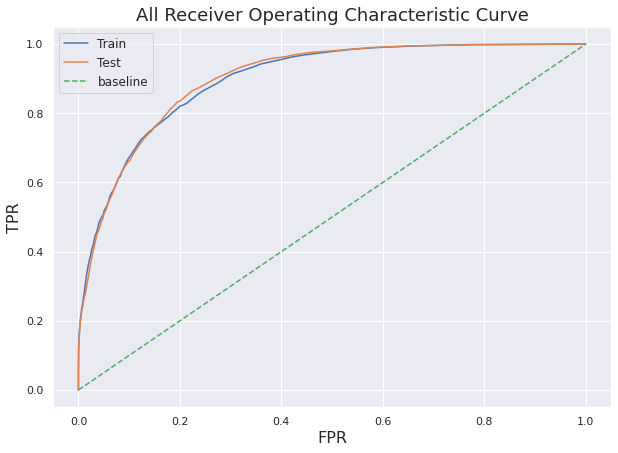

In [ ]:
# #ROCカーブを書く
# fig, ax = plt.subplots(figsize=(10,7))
# ax.plot(fprtr_values, tprtr_values,label='Train')
# ax.plot(fprte_values, tprte_values,label='Test')
# ax.plot(np.linspace(0, 1, 100),
#          np.linspace(0, 1, 100),
#          label='baseline',
#          linestyle='--')
# plt.title('All Receiver Operating Characteristic Curve', fontsize=18)
# plt.ylabel('TPR', fontsize=16)
# plt.xlabel('FPR', fontsize=16)
# plt.legend(fontsize=12);
# #plt.xlim(0,1)
# #plt.ylim(0,1)

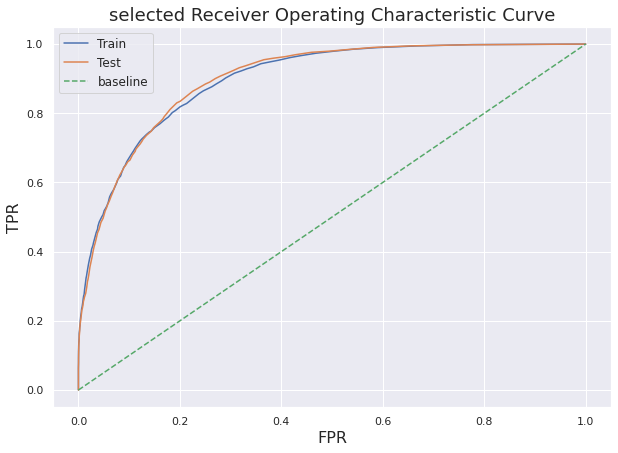

In [ ]:
#ROCカーブを書く
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fprtrs_values, tprtrs_values,label='Train')
ax.plot(fprtes_values, tprtes_values,label='Test')
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('selected Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);
#plt.xlim(0,1)
#plt.ylim(0,1)

In [ ]:
print (f'変数選択後 訓練: {roc_auc_score(y_train, model.predict(sm.add_constant(X_train[selected],prepend=False)) )}')
print (f'変数選択後 検証: {roc_auc_score(y_test, model.predict(sm.add_constant(X_test[selected],prepend=False)) )}')

変数選択後 訓練: 0.8987147535944354
変数選択後 検証: 0.9011204839467808


In [ ]:
# print (f'変数選択前 訓練: {roc_auc_score(y_train, model_all.predict(sm.add_constant(X_train,prepend=False)) )}')
# print (f'変数選択前 検証: {roc_auc_score(y_test, model_all.predict(sm.add_constant(X_test,prepend=False)) )}')

変数選択前 訓練: 0.8988507030141151
変数選択前 検証: 0.9011533666015634
